In [4]:
import os
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2

In [7]:
class ViperData():
    def __init__(self, batch_size=32, image_size=128, align_object=True, train_proportion=1):
        self.name = 'viper'
        self.train_img_dir = '/media/yi/DATA/data-orig/VIPER/train/img/1'
        self.test_img_dir = '/media/yi/DATA/data-orig/VIPER/val/img/1'
        self.train_box_dir = '/home/yi/code/few_shot/viper/train/bb'
        self.test_box_dir = '/home/yi/code/few_shot/viper/val/bb'
        self.train_meta = self.get_meta(self.train_img_dir, self.train_box_dir)
        self.test_meta = self.get_meta(self.test_img_dir, self.test_box_dir)

        self.batch_size = batch_size
        self.im_size = image_size
        self.align_object= align_object
        self.train_proportion = train_proportion

        num_image = len(self.train_meta['img'])
        self.train_meta['img'] = self.train_meta['img'][0:int(num_image * train_proportion)]
        self.train_meta['box'] = self.train_meta['box'][0:int(num_image * train_proportion)]
        print len(self.train_meta['img'])
        self.train_idx = np.random.permutation(len(self.train_meta['img']))
        self.train_cnt = 0
        self.test_idx = np.random.permutation(len(self.test_meta['img']))
        self.test_cnt = 0

        self.compute_statistics('train')
        self.compute_statistics('test')

        self.class_map = {19:0, 20:1, 23:2, 24:3, 25:4, 26:5, 27:6}

    def get_meta(self, img_dir, box_dir):
        meta = {}
        meta['img'], meta['box'] = [], []
        for sub_dir in os.listdir(box_dir):
            box_files = os.listdir(os.path.join(box_dir, sub_dir))
            box_files.sort(key=lambda f: int(filter(str.isdigit, f)))
            box_file_names = [os.path.join(box_dir, sub_dir, f) for f in box_files]
            img_files = []
            for f in box_files:
                file_name, file_ext = os.path.splitext(f)
                img_files.append(file_name + '.jpg')
            img_file_names = [os.path.join(img_dir, sub_dir, f) for f in img_files]
            meta['img'].extend(img_file_names)
            meta['box'].extend(box_file_names)
        # print meta['img'][0:10], meta['box'][0:10], len(meta['img']), len(meta['box'])
        return meta

    def compute_statistics(self, status='train'):
        if status == 'train':
            box_meta = self.train_meta['box']
        else:
            box_meta = self.test_meta['box']
        box = []
        for box_file_name in box_meta:
            with open(box_file_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
        box = np.array(box).astype(np.float)

        cls = box[:, 0]
        box = box[:, 1:5]
        cls_labels = set(list(cls))
        count = dict()
        max_count = 0
        total_count = 0
        for cls_label in cls_labels:
            count[cls_label] = (cls == cls_label).sum()
            if count[cls_label] > max_count:
                max_count = count[cls_label]
            total_count = total_count + count[cls_label]
        print(status)
        print(count)
        print(max_count * 1.0 / total_count)

    def get_next_batch(self, status='train'):
        batch_size, im_size = self.batch_size, self.im_size
        im = np.zeros((batch_size, im_size, im_size, 3))
        label = np.zeros(batch_size)
        i = 0
        while i < batch_size:
            if status == 'train':
                image_name = self.train_meta['img'][self.train_idx[self.train_cnt]]
                box_name = self.train_meta['box'][self.train_idx[self.train_cnt]]
            else:
                image_name = self.test_meta['img'][self.test_idx[self.test_cnt]]
                box_name = self.test_meta['box'][self.test_idx[self.test_cnt]]
            image = np.array(Image.open(image_name))
            # image = cv2.imread(image_name)
            # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # image[:, :, 0] = clahe.apply(image[:, :, 0])
            # image[:, :, 1] = clahe.apply(image[:, :, 1])
            # image[:, :, 2] = clahe.apply(image[:, :, 2])
            image = image / 255.0
            box = []
            with open(box_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
            box = np.array(box).astype(np.int)

            if status == 'train':
                self.train_cnt = self.train_cnt + 1
                if self.train_cnt >= len(self.train_meta['img']):
                    self.train_idx = np.random.permutation(len(self.train_meta['img']))
                    self.train_cnt = 0
            else:
                self.test_cnt = self.test_cnt + 1
                if self.test_cnt >= len(self.test_meta['img']):
                    self.test_idx = np.random.permutation(len(self.test_meta['img']))
                    self.test_cnt = 0

            for n in range(box.shape[0]):
                cls = box[n, 0]
                bb = box[n, 1:5]
                crop_im = self.crop_image(image, bb, im_size)
                im[i, :, :, :] = cv2.resize(crop_im, (im_size, im_size), interpolation=cv2.INTER_AREA)
                label[i] = self.class_map[cls]
                i = i + 1
                if i >= batch_size:
                    break
        im = im.transpose((0, 3, 1, 2))
        return im, label

    def crop_image(self, image, bb, im_size):
        im_height, im_width = image.shape[0], image.shape[1]
        x_c, y_c = (bb[0] + bb[2]) / 2, (bb[1] + bb[3]) / 2
        width, height = bb[2] - bb[0], bb[3] - bb[1]
        if self.align_object:
            height = height * 2
            width = width * 2
        else:
            height = np.random.randint(height * 2, height * 5)
            width = np.random.randint(width * 2, width * 5)

        y_s = max(0, y_c - height / 2)
        y_e = min(im_height, y_c + height / 2)
        x_s = max(0, x_c - width / 2)
        x_e = min(im_width, x_c + width / 2)
        im = image[y_s:y_e, x_s:x_e, :]
        return im

    def display(self, im, label):
        img = im[0, :, :, :].transpose(1, 2, 0)

        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # print(img)
        print(label[0])

64315
train
{19.0: 4058, 20.0: 11379, 23.0: 1601, 24.0: 54672, 25.0: 2031, 26.0: 5540, 27.0: 20015}
0.5505961972284885
test
{19.0: 945, 20.0: 1925, 23.0: 915, 24.0: 27846, 25.0: 959, 26.0: 1654, 27.0: 11060}
0.6146477132262052


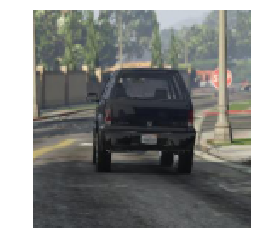

3.0


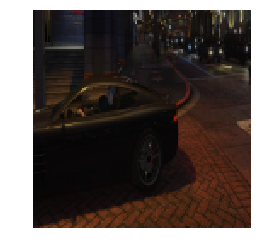

3.0


In [10]:
batch_size = 32
image_size = 128
align_object = True
train_proportion = 1
data = ViperData(batch_size, image_size, align_object, train_proportion)
data.align_object = True
im, label = data.get_next_batch('train')
data.display(im, label)
im, label = data.get_next_batch('test')
data.display(im, label)